In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import Image as DisplayImage
from PIL import Image as PILImage
from fastai.vision import *
from fastai.vision.gan import *
import torch
import torch.nn as nn
import torch.nn.functional as F

You should set the following option to True if the notebook isn't located in the file system inside a clone of the git repo (with the needed Python modules available) it belongs to; i.e., it's running independently.

In [0]:
run_as_standalone_nb = True

In [43]:
# This cell needs to be executed before importing local project modules, like import core.gan
if run_as_standalone_nb:
    root_lib_path = os.path.abspath('generative-lab')
    if not os.path.exists(root_lib_path):
        !git clone https://github.com/davidleonfdez/generative-lab.git
    if root_lib_path not in sys.path:
        sys.path.insert(0, root_lib_path)
else:
    import local_lib_import

Cloning into 'generative-lab'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 426 (delta 68), reused 108 (delta 41), pack-reused 286
Receiving objects: 100% (426/426), 304.50 MiB | 37.66 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Checking out files: 100% (48/48), done.


In [0]:
# Local project modules. Must be imported after local_lib_import or cloning git repo.
from core.gan import (CustomGANLearner, GenImagesSampler, load_gan_learner, load_gan_generator,
                      save_gan_learner, train_checkpoint_gan)
from core.gan_display import display_gan_out_tensor
from core.nb_utils import mount_gdrive
from core.net_builders import pseudo_res_critic, pseudo_res_generator

In [0]:
img_size = 64
img_n_channels = 3
batch_size = 64

In [0]:
models_root = './'

# DATA

In [41]:
torch.cuda.is_available()

True

In Kaggle, you can easily add the CelebA dataset. For other environments, you probably need to manually download the dataset from https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8

In [0]:
real_images_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/')
real_images_path

In [0]:
sample_img_path = next(real_images_path.glob('**/*.jpg'))
sample_img_path

In [16]:
im = PILImage.open(sample_img_path)
im.size

(178, 218)

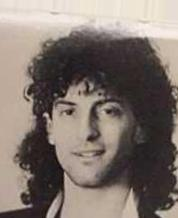

In [17]:
DisplayImage(filename=str(sample_img_path))

In [0]:
def get_data(path, bs, size, noise_sz=100):
    return (GANItemList.from_folder(path, noise_sz=noise_sz)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=0.5, col_pct=0.5)], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

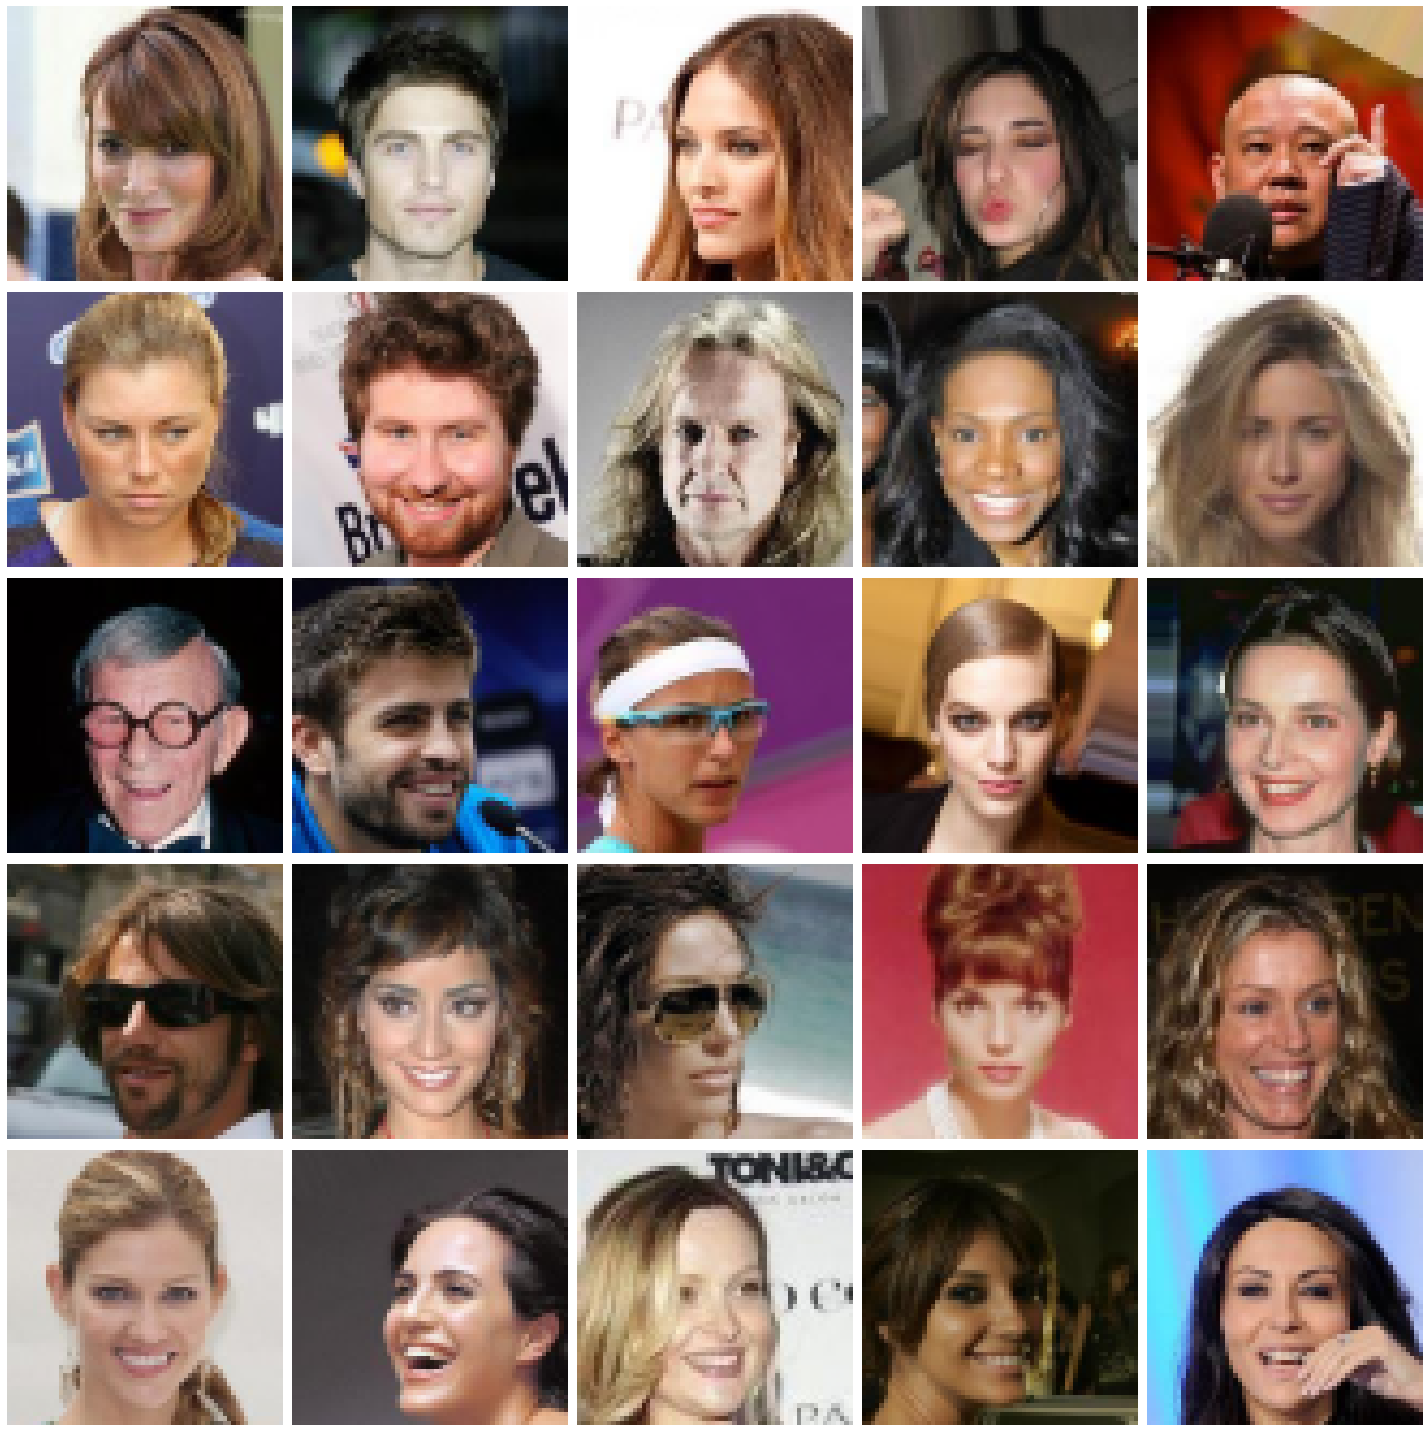

In [21]:
data = get_data(real_images_path, batch_size, img_size)
data.show_batch()

In [22]:
data

ImageDataBunch;

Train: LabelList (202599 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /content/img_align_celeba;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: /content/img_align_celeba;

Test: None

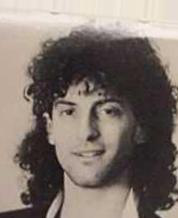

In [27]:
data.y[0]

In [28]:
data.y[0].size

torch.Size([218, 178])

# GENERATOR

Let's create the generator with the helper method that fastai provides.

Input is bs x noise_sz * 1 * 1<br>
**n_features** is the number of feature maps (so kernels) generated after penultimate layer (the last layer of course outputs n_channels) if n_extra_layers = 0 . At the beginning there will be n_features * 2^(n_intermediate_convtrans_blocks), and this number will be reduced by half in any subsequent layer.

`basic_generator(in_size:int, n_channels:int, noise_sz:int=100, n_features:int=64, n_extra_layers=0, **conv_kwargs)`

In [0]:
generator = basic_generator(img_size, img_n_channels)

# CRITIC

Let's create the discriminator with the helper method that fastai provides.<br>

**n_features** is the number of feature maps (so kernels) generated after first layer (from the n_channels of the input). This number will be doubled in any subsequent layer.

`basic_critic(in_size:int, n_channels:int, n_features:int=64, n_extra_layers:int=0, **conv_kwargs)`

In [0]:
critic = basic_critic(img_size, img_n_channels)

# GAN LEARNER

In [0]:
learner = CustomGANLearner.wgan(data, generator, critic)

# TRAINING

## First config: default hyperparameters (wd=0.01, Adam(beta1=0.9,beta2=0.99)), lr=1e-4

In [0]:
lr = 1e-4
learner.fit(5, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr1_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr1_10ep.pth')

## Second config: use fastai recommended hyperparameters

In [0]:
lr = 2e-4
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr2_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr2_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr2_15ep.pth')

This way we can show results in a session other than when we ran `learner.fit()`:

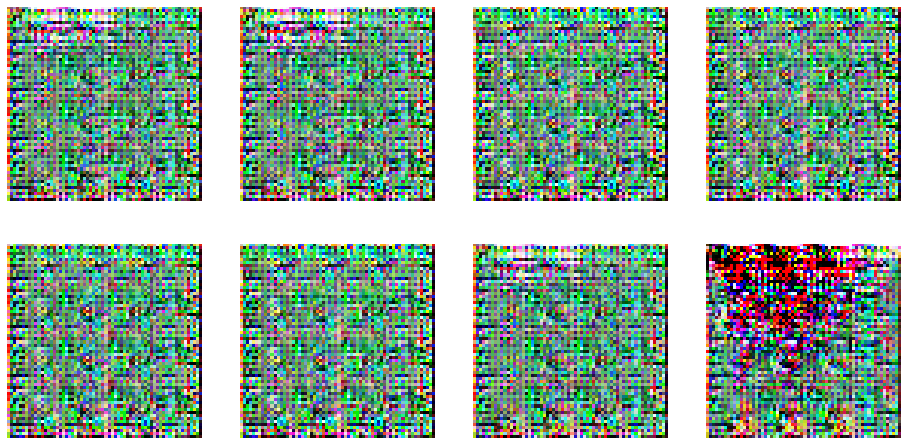

In [48]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan_celeba_tr2_15ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## Third config: increment batch size

In [0]:
lr = 2e-4
data = get_data(real_images_path, 128, img_size)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr3_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr3_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr3_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr3_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---

Showing results after returning to work...

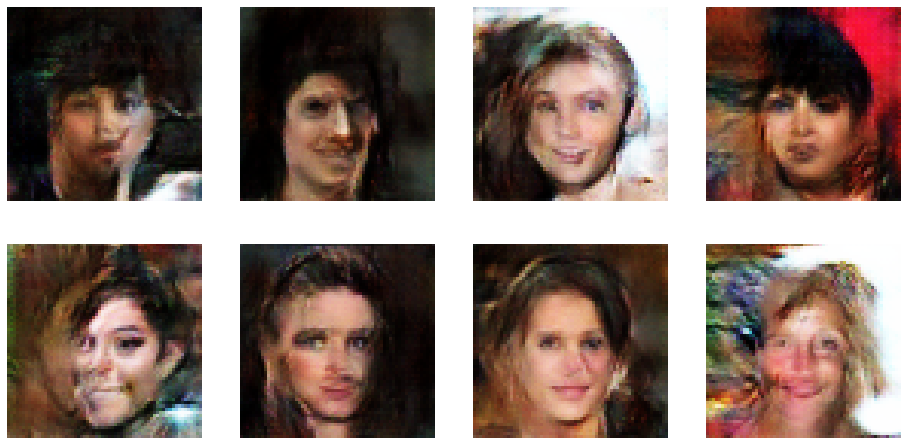

In [49]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan_celeba_tr3_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## Fourth config: use standard Adam parameters

In [0]:
lr = 2e-4
data = get_data(realImagesPath, 128, img_size)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.9,0.999)), wd=0.)
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr4_5ep.pth')

## Fifth config: smaller noise vector

In [0]:
noise_sz = 60

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size, noise_sz=noise_sz)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1, noise_sz=noise_sz)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr5_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr5_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr5_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr5_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

In [0]:
# Leave data as it was
data = get_data(real_images_path, batch_size, img_size)

---

Showing results after returning to work:

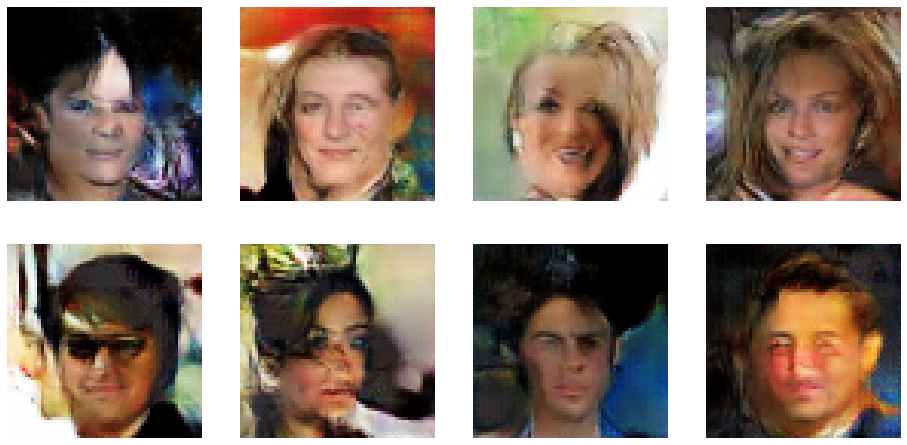

In [57]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1, noise_sz=noise_sz)
load_gan_generator(generator, models_root + 'wgan_celeba_tr5_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator, noise_sz).get(8))

## Sixth config: add residual blocks

### 6.1: Add residual blocks in critic and generator

In [0]:
lr = 2e-4
generator = pseudo_res_generator(img_size, img_n_channels)
critic = pseudo_res_critic(img_size, img_n_channels)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)

In [0]:
learner.fit(10, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr6_1_20ep.pth')

### 6.2: Using bigger batch size...

In [0]:
generator = pseudo_res_generator(img_size, img_n_channels)
critic = pseudo_res_critic(img_size, img_n_channels)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)

In [0]:
learner.fit(10, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr6_2_20ep.pth')

#### 6.2.2 With two extra layers

Theoretically extra layers at the end should give better results (or not worse) if residual, which is not the case right now, maybe could try it later.

In [0]:
lr = 2e-4
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=2)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=2)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_2_2_10ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

Quite poor results, no need to go on

In [0]:
learner.fit(10, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_2_2_20ep.pth')

---
Showing results after returning to work:

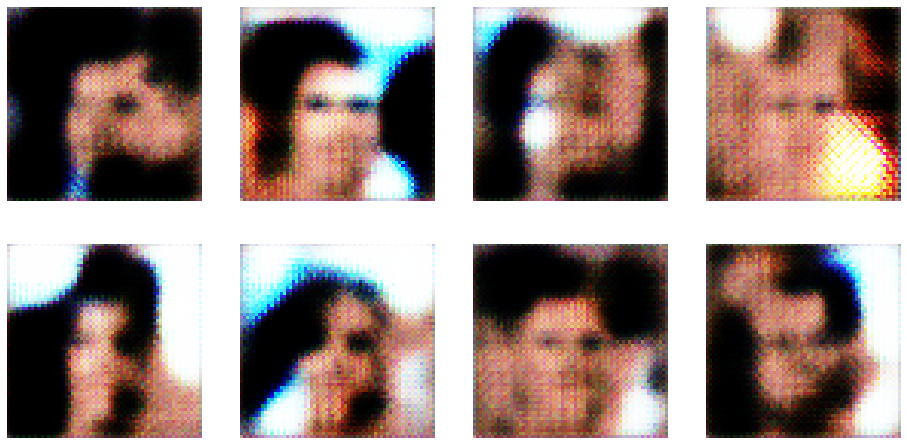

In [60]:
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=2)
load_gan_generator(generator, models_root + 'wgan_celeba_tr6_2_2_10ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### 6.2.3 With one extra layer

In [0]:
data = get_data(real_images_path, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_2_3_10ep.pth')

In [0]:
learner.fit(10, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_2_3_20ep.pth')

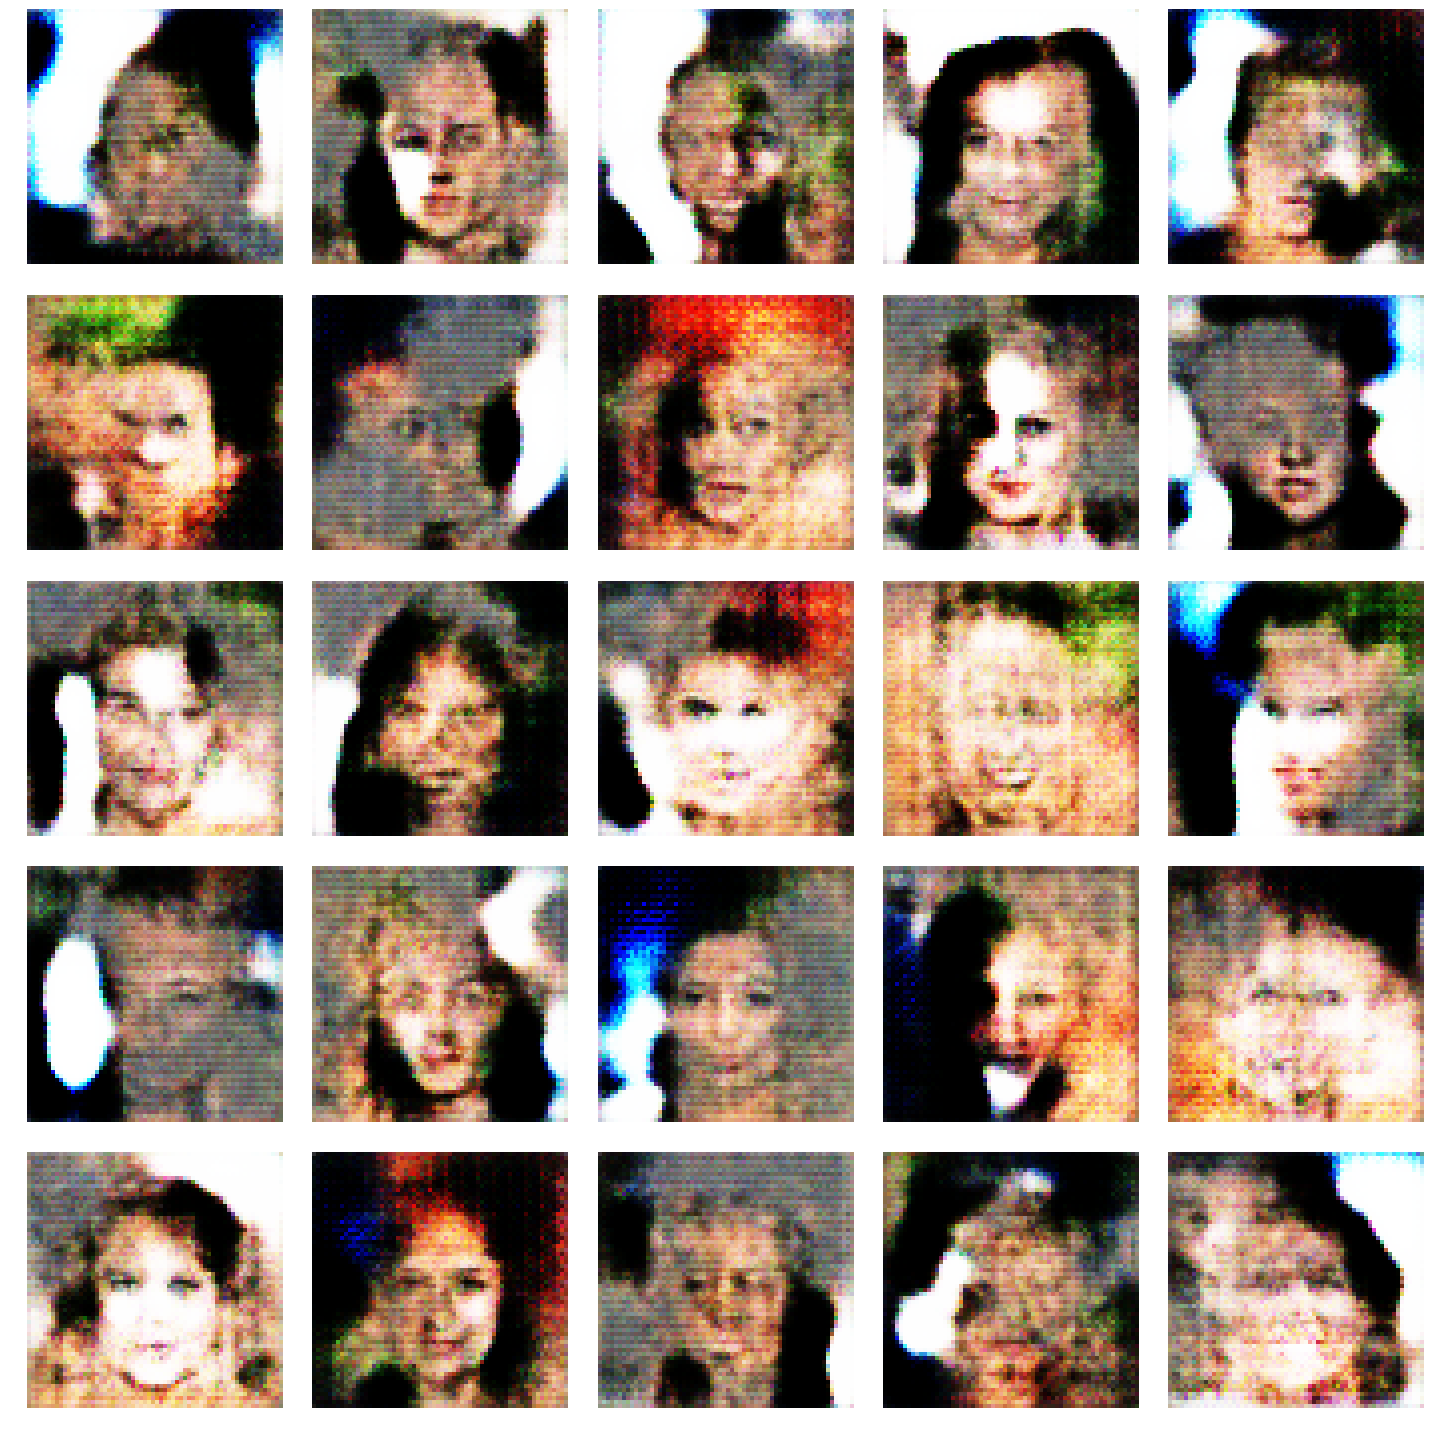

In [0]:
learner.show_results(ds_type=DatasetType.Train)

#### 6.2.4: Switch the order of residual and conv blocks in critic

In [0]:
lr = 2e-4
data = get_data(realImagesPath, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=1, conv_before_res=False)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)

In [0]:
learner.fit(10, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr6_2_4_20ep.pth')

#### 6.2.5 With bigger learning rate...

In [0]:
lr = 1e-3
data = get_data(realImagesPath, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=1, conv_before_res=False)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)

In [0]:
learner.fit(10, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr6_2_5_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

#### 6.2.6 With not so big lr...

In [0]:
lr = 5e-4
data = get_data(realImagesPath, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=1, conv_before_res=False)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)

In [0]:
learner.fit(10, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr6_2_6_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### 6.3: Use residual blocks only in critic

In [0]:
lr = 2e-4
data = get_data(realImagesPath, 128, img_size)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=1)
learner = GANLearner.wgan(data, generator, critic, switch_eval=False, 
                          opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(10, lr)

In [0]:
learner.fit(10, lr)

In [0]:
save_gan_learner(learner, 'wgan_celeba_tr6_3_20ep.pth')

### 6.4: Use residual blocks only in generator

In [0]:
lr = 2e-4
data = get_data(real_images_path, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_4_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_4_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_4_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr6_4_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work:

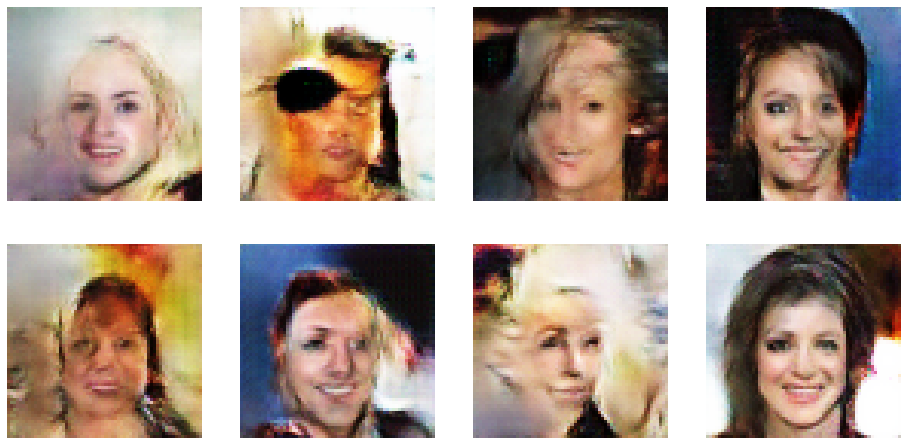

In [69]:
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan_celeba_tr6_4_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## Seventh config: add dense blocks

### 7.1: Dense both critic and generator

In [0]:
lr = 2e-4
data = get_data(real_images_path, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1, dense=True)
critic = pseudo_res_critic(img_size, img_n_channels, n_extra_layers=1, dense=True)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr7_1_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr7_1_10ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

Too bad, no need to go on

### 7.2: Dense generator only

In [0]:
lr = 2e-4
data = get_data(real_images_path, 128, img_size)
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1, dense=True)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr7_2_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, 'wgan_celeba_tr7_2_10ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

Too bad, no need to go on

---
Showing results after returning to work:

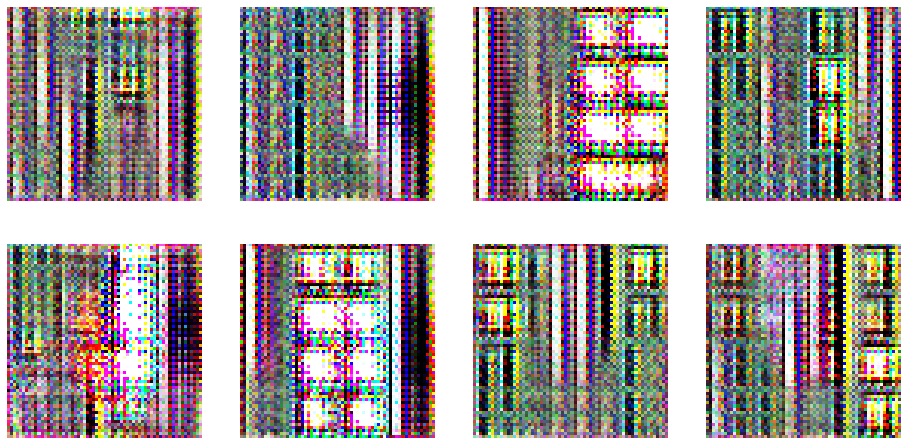

In [70]:
generator = pseudo_res_generator(img_size, img_n_channels, n_extra_layers=1, dense=True)
load_gan_generator(generator, models_root + 'wgan_celeba_tr7_2_10ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))